In [1]:
#Limit dates to plot
N_days=60 # number of days to include
bad_cutoff=20000 # minimum number of tests to consider good

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import requests
import zipfile
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from datetime import date, timedelta

In [3]:
# Find link to latest file from the web page
# assumes stabel initial part of filename and webpage location
req = Request("https://www.ssi.dk/sygdomme-beredskab-og-forskning/sygdomsovervaagning/c/covid19-overvaagning")
html_page = urlopen(req)
soup = BeautifulSoup(html_page, "html")
                     
for link in soup.findAll('a'):
    ref=link.get('href')
    if isinstance(ref, str) and "data-epidemiologisk-rapport" in ref.lower(): # NB compare in lower case
        print("url for zip file: " + link.get('href'))
        url=link.get('href')
        


url for zip file: https://files.ssi.dk/Data-epidemiologisk-rapport-05112020-fup2


In [4]:
#Defin todays URL manualy if above code breaks
#url = 'https://files.ssi.dk/Data-epidemiologisk-rapport-05112020-fup2'


In [5]:
# Direct download data and unpacking
r = requests.get(url, allow_redirects=True)
open('data.zip', 'wb').write(r.content)

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("data/")

#define the file to read
datafolder=Path("data/")
datafile=datafolder / "Test_pos_over_time.csv"

In [6]:
# Read datafile
# Skips last two lines (which does not convert to date) and converts index to date
# Notice handeling of danish format of the numbers (both decimal and thousands)
df=pd.read_csv(datafile,  sep=';', parse_dates=['Date'], index_col=['Date'],error_bad_lines=False, engine='python', skipfooter=2, decimal=',', thousands='.')


In [7]:
# calculate some more numbers

# Positive emperical scaled by number of tests to power of 0.7  
# This scaling is based on results in 
# SSI "Ekspertrapport af d. 23. oktober 2020 Incidens og fremskrivning af COVID-19 tilfælde"
# https://www.ssi.dk/-/media/ssi-files/ekspertrapport-af-den-23-oktober-2020-incidens-og-fremskrivning-af-covid19-tilflde.pdf?la=da
def calcScaledNumber (row):
    if row.NotPrevPos > 0 :
        return row.NewPositive / (row.NotPrevPos**0.7)
    else:
        return 0
    
df['ScaledNumber']=df.apply(lambda row: calcScaledNumber(row), axis=1)    

# Recalculate Positiv procent to get more decimals for plotting
def calcPosPct (row):
    if row.NotPrevPos > 0 :
        return row.NewPositive / row.NotPrevPos * 100
    else:
        return 0
df['PosPct']=df.apply(lambda row: calcPosPct(row), axis=1)


In [8]:
# for easy plot make a sub data frame with selected number of days 
df_sel=df[date.today()-timedelta(days=N_days):]

# and make index for "bad" datapoints
bad_idx=df_sel['NotPrevPos']<bad_cutoff

In [9]:
# define a common title including date from file
title_str='SSI COVID-19 data, tilfælde opgjort på prøvetagningsdato \n' 
title_str += url[49:57]

<IPython.core.display.Javascript object>


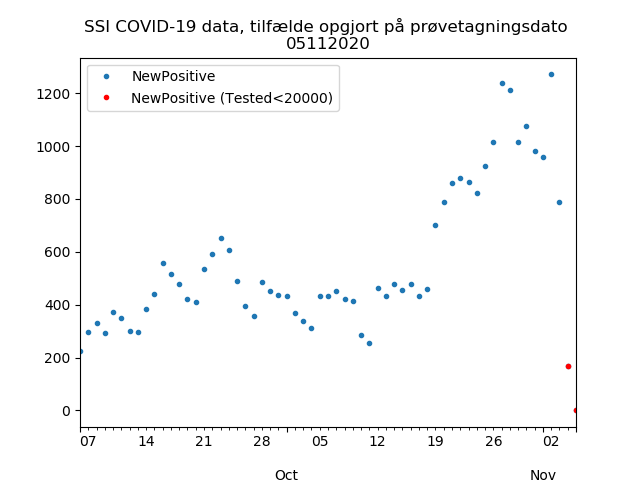

In [10]:
ax=df_sel.plot(y='NewPositive',title=title_str,style='.');
df_sel[bad_idx].plot(ax=ax,y='NewPositive',style='.',color='red',label='NewPositive (Tested<'+ str(bad_cutoff) + ')');


<IPython.core.display.Javascript object>


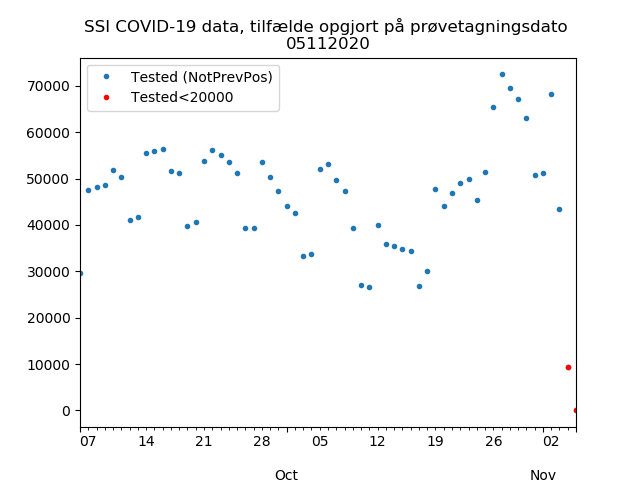

In [11]:
ax=df_sel.plot(y='NotPrevPos',label='Tested (NotPrevPos)',title=title_str,style='.');
df_sel[bad_idx].plot(ax=ax,y='NotPrevPos',style='.',color='red',label='Tested<'+ str(bad_cutoff) + '');

<IPython.core.display.Javascript object>


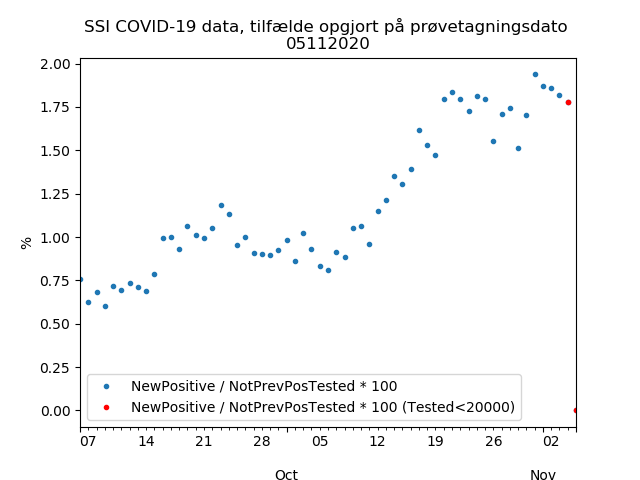

In [12]:
ax=df_sel.plot(y='PosPct',title=title_str,label='NewPositive / NotPrevPosTested * 100',style='.');
df_sel[bad_idx].plot(ax=ax,y='PosPct',style='.',color='red',label='NewPositive / NotPrevPosTested * 100 (Tested<'+ str(bad_cutoff) + ')');
ax.set_ylabel("%");
#plt.savefig('plot.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


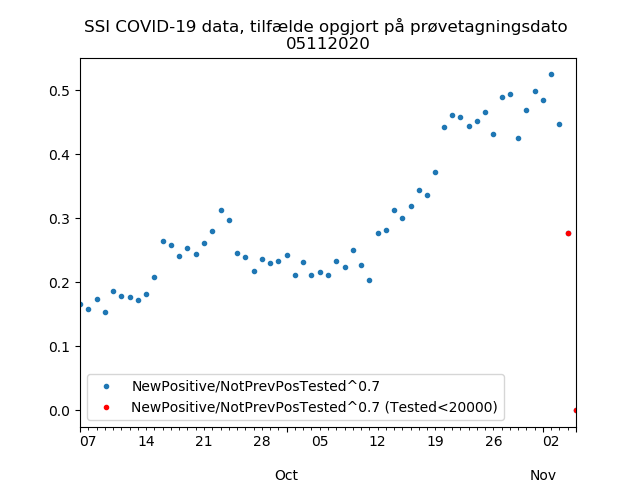

In [13]:
ax=df_sel.plot(y='ScaledNumber',title=title_str,label='NewPositive/NotPrevPosTested^0.7',style='.');
df_sel[bad_idx].plot(ax=ax,y='ScaledNumber',style='.',color='red', label='NewPositive/NotPrevPosTested^0.7 (Tested<'+ str(bad_cutoff) + ')');

#plt.savefig('plot2.png', dpi=300, bbox_inches='tight')
#plt.show()
# This scaling is based on 
# SSI "Ekspertrapport af d. 23. oktober 2020 Incidens og fremskrivning af COVID-19 tilfælde"
# https://www.ssi.dk/-/media/ssi-files/ekspertrapport-af-den-23-oktober-2020-incidens-og-fremskrivning-af-covid19-tilflde.pdf?la=da

<IPython.core.display.Javascript object>


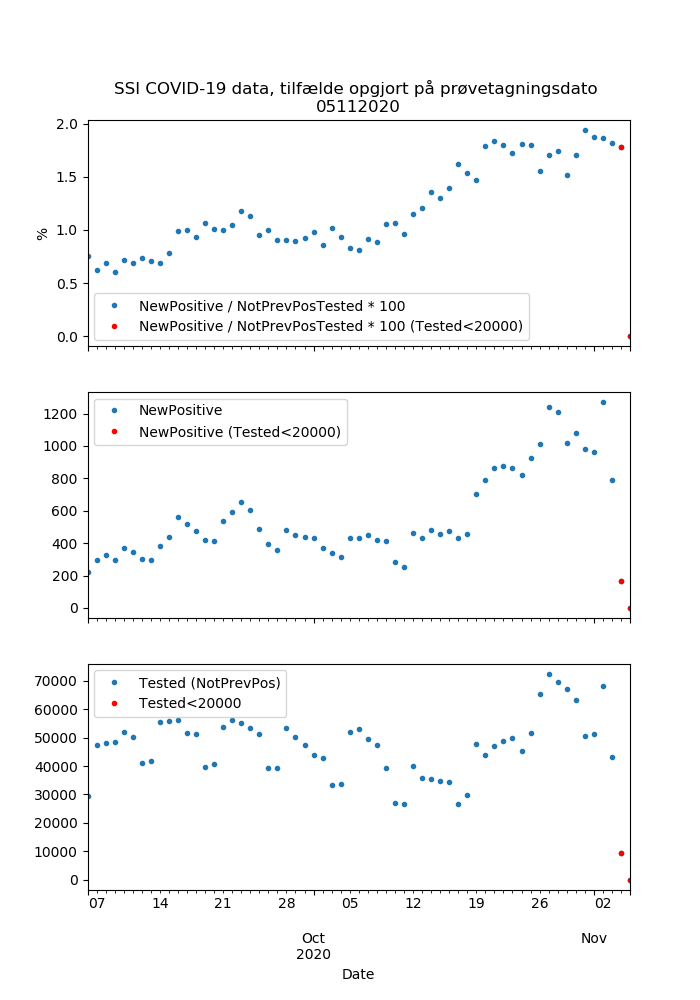

In [14]:
#gs = fig.add_gridspec(3,1, hspace=0)
#axs = gs.subplots(sharex=True)

#fig, axs = plt.subplots(3,figsize=(7, 10))
#plt.subplots_adjust(hspace=0.5)
axs=[None]*3 #define axs list as empty 3 entries
fig = plt.figure(figsize=(7, 10))
axs[0] = plt.subplot(311)
axs[1] = plt.subplot(312,sharex=axs[0])
axs[2] = plt.subplot(313,sharex=axs[0])


df_sel.plot(ax=axs[0],y='PosPct',title=title_str,label='NewPositive / NotPrevPosTested * 100',style='.');
df_sel[bad_idx].plot(ax=axs[0],y='PosPct',style='.',color='red',label='NewPositive / NotPrevPosTested * 100 (Tested<'+ str(bad_cutoff) + ')');
axs[0].set_ylabel("%");

#df_sel.plot(ax=axs[1], y='ScaledNumber',label='NewPositive/NotPrevPosTested^0.7',style='.');
#df_sel[bad_idx].plot(ax=axs[1],y='ScaledNumber',style='.',color='red', label='NewPositive/NotPrevPosTested^0.7 (Tested<'+ str(bad_cutoff) + ')');

df_sel.plot(ax=axs[1],y='NewPositive',style='.');
df_sel[bad_idx].plot(ax=axs[1],y='NewPositive',style='.',color='red',label='NewPositive (Tested<'+ str(bad_cutoff) + ')');

df_sel.plot(ax=axs[2],y='NotPrevPos',label='Tested (NotPrevPos)',style='.');
df_sel[bad_idx].plot(ax=axs[2],y='NotPrevPos',style='.',color='red',label='Tested<'+ str(bad_cutoff) + '');